In [4]:
print("Hello World")

Hello World


# Practical Budget Pacing Algorithms, PID Controler and Simulation Test Bed for eBay Marketplace Sponsored Search

Recreation of the simulations and techniques used by Ebay in this paper http://papers.adkdd.org/2023/papers/adkdd23-nguyen-practical.pdf


This notebook adds:
- Adds a new PID control method and compares with the pacing algorithms used in the paper
- Simulates user-interaction data, as we don't have access to it. 



In [7]:
import pandas as pd


In [2]:
# Simulate 1440 minutes in a day
# Simulate bids for competing campaigns (3 campaigns with different budgets)
# Calculate Metrics for each campaign
# Use different pacing algorithms to spend budget
# Add PID to each campaign
# Build a nice UI


# Create dataframe that has
# Keyword, Item, Time, pCTR(probability of click through rate), bid




In [8]:
# Simulate 1440 minutes in a day, M campaigns competing for N keywords, pCTR, bid

# Define data
data = {
    # Each item is a book that represents a campaign
    'Item': ['Time Series Analysis: Forecasting and Control', 'Practical Statistics for Data Scientists', 'Designing Data-Intensive Applications'],
    # They are all bidding on the same keyword
    'Keyword': ['statistics book', 'statistics book', 'statistics book'],
    # Probability of click through rate (This is a guess as we don't have the actual data)
    'pCTR': [0.03, 0.04, 0.02],
    # Bid amount (this will be randomized around this central amount)
    'Bid': [0.5, 0.48, 0.55],
    'Budget': [5000,5000,2000],
    'Spend': [0.0,0.0,0.0],
}

# Create DataFrame
items_keywords_df = pd.DataFrame(data)

# Print DataFrame
display(items_keywords_df)

,Item,Keyword,pCTR,Bid,Budget,Spend
0,Time Series Analysis: Forecasting and Control,statistics book,0.03,0.50,5000,0.0
1,Practical Statistics for Data Scientists,statistics book,0.04,0.48,5000,0.0
2,Designing Data-Intensive Applications,statistics book,0.02,0.55,2000,0.0


In [9]:
# Simulate a bid around a keyword
   # This should will take modifiers from control algorithms
import numpy as np
def auction(df):
    """
    Gets df with bidding information and simulates an auction
    
    Returns winner and price paid
    
    """
    bid_dict = {}
    for index, id in df.iterrows():
        bid_dict[index] = id['Bid']- np.random.uniform(0.0, 0.2)
    winner = max(bid_dict, key=bid_dict.get)
    try:
        # price paid is the bid of the second highest bidder
        price_paid = sorted(bid_dict.values(), reverse=True)[1]
    except:
        # If there is only one bidder, the price paid is the bid of the winner
        price_paid = bid_dict[winner]
    return winner, price_paid

winner, price_paid = auction(items_keywords_df)

print(f"The winner is {items_keywords_df.loc[winner]['Item']}")
print(f"The price paid is {price_paid}")

The winner is Designing Data-Intensive Applications
The price paid is 0.4303918473493127


In [13]:
test_df = items_keywords_df.copy()

def decide_budget_proportional_choice(Budget, Spend) -> int:
    """
    Choose a campaign based on the proportion of budget spent
    """
    p = (Budget - Spend) / Budget
    #ensure p is between 0 and 1
    p = max(0, min(1, p))
    return np.random.choice([0, 1], p=[1-p, p])

decide_budget_proportional_choice(1000, 500)

test_df['Enter_bid'] = test_df.apply(lambda x: decide_budget_proportional_choice(x['Budget'], x['Spend']), axis=1)
test_df[test_df['Enter_bid'] == 1]


,Item,Keyword,pCTR,Bid,Budget,Spend,Enter_bid
0,Time Series Analysis: Forecasting and Control,statistics book,0.03,0.50,5000,0.00000,1
1,Practical Statistics for Data Scientists,statistics book,0.04,0.48,5000,0.00000,1
2,Designing Data-Intensive Applications,statistics book,0.02,0.55,2000,-1.82728,1


In [11]:
# Add number of clicks, total spend, CTR, CPC
def calc_clicks(pCTR, total_impressions = 1000):
    return total_impressions * pCTR

def calc_total_spend(clicks, price_paid):
    return clicks * price_paid

In [14]:
# Simulate unlimited budget over 1440 minutes
# iterate over 1440 minutes (flat traffic)
# Save the winner and price paid
# Build a dataframe with the results

simulation_results = []
for minute in range(1440):
    # TODO(Raul): Add choice
    # Remove winner if Spend is greater than Budget
    #items_keywords_df = items_keywords_df[items_keywords_df['Spend'] < items_keywords_df['Budget']]
    
    # Choose who enters the bid (% to budget strategy)
    
    selection_df = items_keywords_df.copy()
    
    selection_df['Enter_bid'] = selection_df.apply(lambda x: decide_budget_proportional_choice(x['Budget'], x['Spend']), axis=1)
    selection_df = selection_df[selection_df['Enter_bid'] == 1]  
    
    # If there are no bidders, skip the minute and save as "No Bid" 
    
    if selection_df.shape[0] == 0:
        simulation_results.append({
            'Minute': minute,
            'Winner': 'No Bid',
            'Price Paid': 0,
            "pCTR": 0,
        })
            
    else:    
            
        winner, price_paid = auction(selection_df)
        result = {
            'Minute': minute,
            'Winner': items_keywords_df.loc[winner]['Item'],
            'Price Paid': price_paid,
            "pCTR": items_keywords_df.loc[winner]['pCTR'] + np.random.normal(-0.01, 0.01),
        }
        
        # Update Spend so far for the winner
        items_keywords_df.loc[winner, 'Spend'] = items_keywords_df.loc[winner, 'Spend'] + calc_total_spend(calc_clicks(result['pCTR']), price_paid)
        
    simulation_results.append(result)
    
simulation_results_df = pd.DataFrame(simulation_results)

In [15]:
simulation_results_df.groupby("Winner").agg({"Price Paid": "mean", "pCTR": "mean", "Minute": "count"})

,Price Paid,pCTR,Minute
Winner,,,
Designing Data-Intensive Applications,0.403985,0.009627,486
No Bid,0.000000,0.000000,185
Practical Statistics for Data Scientists,0.374136,0.030093,421
Time Series Analysis: Forecasting and Control,0.391489,0.019577,533


In [16]:



simulation_results_df['Clicks'] = simulation_results_df.apply(lambda x: calc_clicks(total_impressions=1000, pCTR=x['pCTR']), axis=1)
simulation_results_df['Total Spend'] = simulation_results_df.apply(lambda x: calc_total_spend(x['Clicks'], x['Price Paid']), axis=1)


simulation_results_df.groupby("Winner").agg({"Price Paid": "mean", "pCTR": "mean", "Minute": "count", "Clicks": "sum", "Total Spend": "sum"})

# add cost per click
simulation_results_df['Cost Per Click'] = simulation_results_df['Total Spend'] / simulation_results_df['Clicks']

simulation_results_df.groupby("Winner").agg({"Price Paid": "mean", "pCTR": "mean", "Minute": "count", "Clicks": "sum", "Total Spend": "sum", "Cost Per Click": "mean"})


# Cost per click are very similar for all campaigns
# Can introduce quality scores and impression charges?


,Price Paid,pCTR,Minute,Clicks,Total Spend,Cost Per Click
Winner,,,,,,
Designing Data-Intensive Applications,0.403985,0.009627,486,4678.602095,1877.278432,0.403985
No Bid,0.000000,0.000000,185,0.000000,0.000000,NaN
Practical Statistics for Data Scientists,0.374136,0.030093,421,12669.189533,4729.209742,0.374136
Time Series Analysis: Forecasting and Control,0.391489,0.019577,533,10434.344203,4073.805353,0.391489


In [17]:
items_keywords_df

,Item,Keyword,pCTR,Bid,Budget,Spend
0,Time Series Analysis: Forecasting and Control,statistics book,0.03,0.50,5000,3486.044631
1,Practical Statistics for Data Scientists,statistics book,0.04,0.48,5000,4016.695395
2,Designing Data-Intensive Applications,statistics book,0.02,0.55,2000,1759.145868


0

In [ ]:
TODO:
    - Add Metrics and visualizations over minutes
    - Add a smoothness metric for pacing
    - Add PID

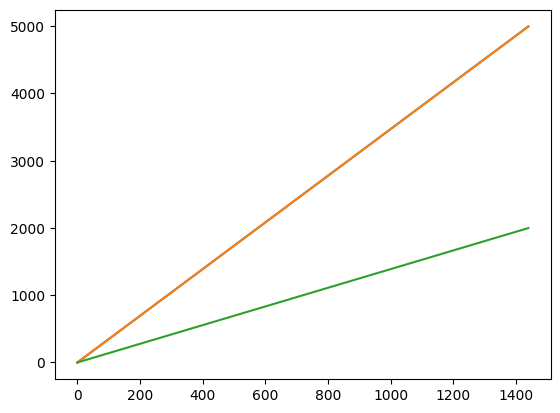

In [23]:
# for every item create a timeseries of 1440 minutes

timeseries = []

for item in items_keywords_df['Item']:
    for  minute in range(1440):
        budget = items_keywords_df[items_keywords_df['Item'] == item]['Budget'].values[0]
        timeseries_row = {
            'Minute': minute,
            'Item': item,
            'cumulative_expected_spend_linear': minute * budget / 1440,
        }
        timeseries.append(timeseries_row)
    
campaign_timeseries_df = pd.DataFrame(timeseries)

#plot
import matplotlib.pyplot as plt

for item in campaign_timeseries_df['Item'].unique():
    plt.plot(campaign_timeseries_df[campaign_timeseries_df['Item'] == item]['Minute'], campaign_timeseries_df[campaign_timeseries_df['Item'] == item]['cumulative_expected_spend_linear'], label=item)

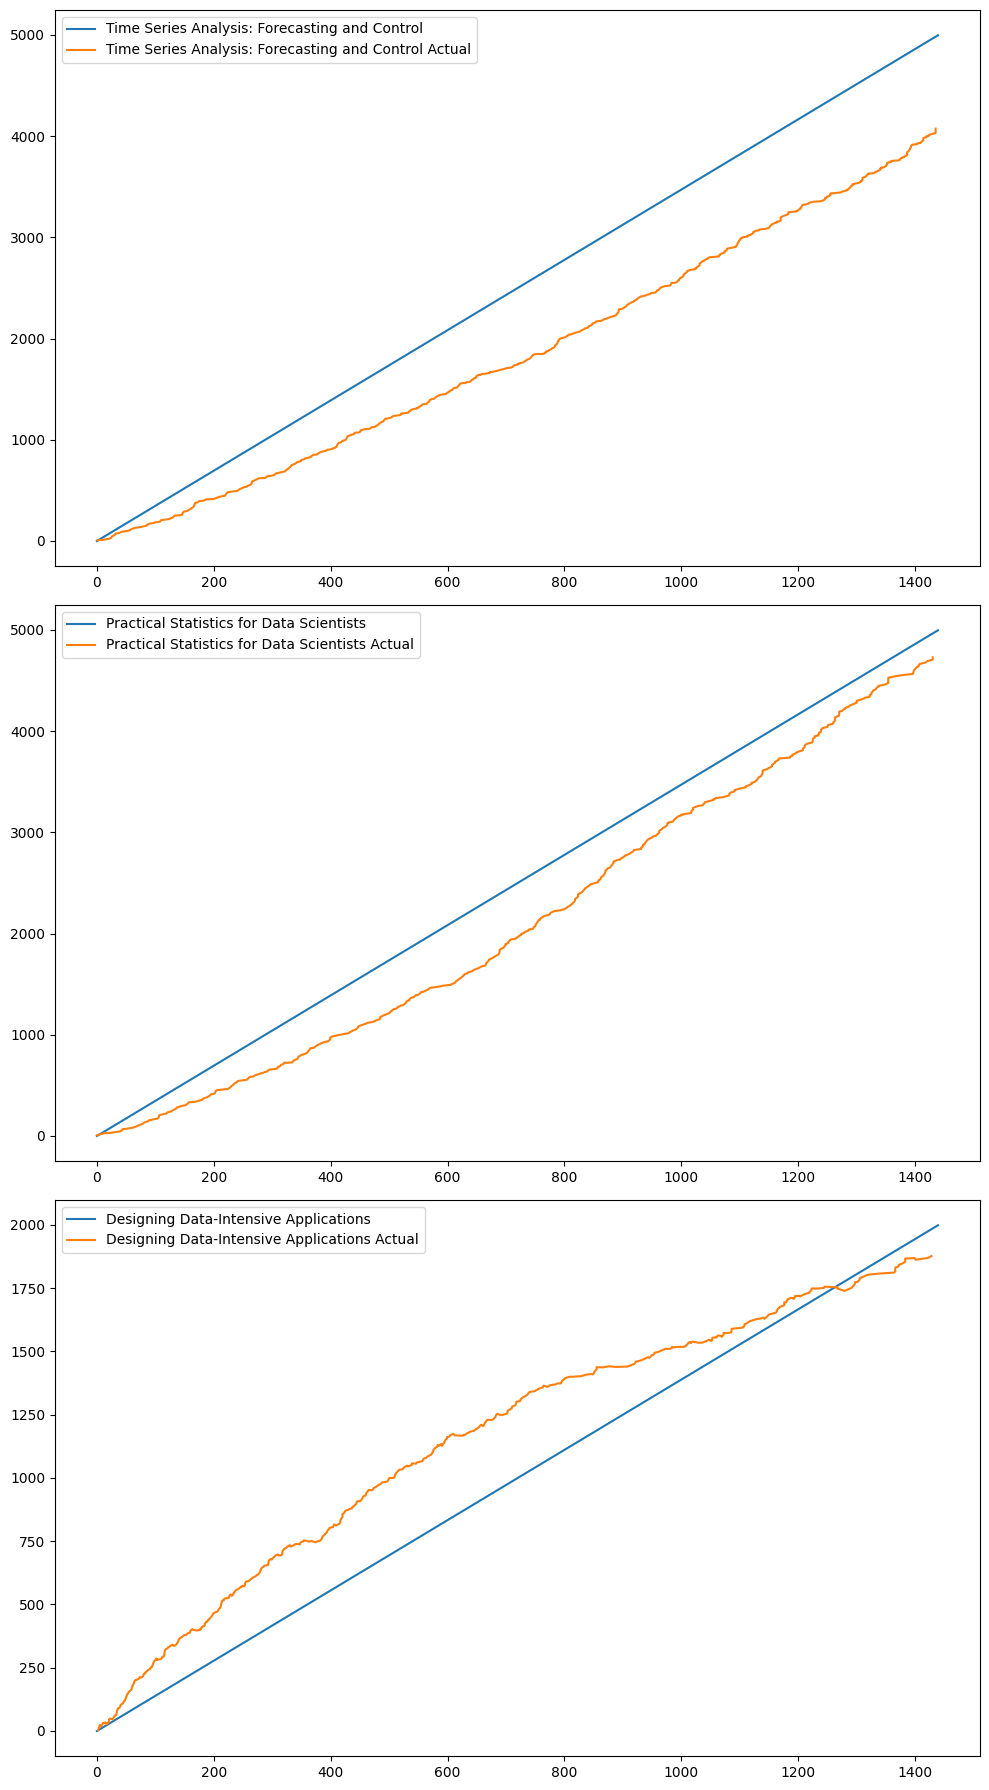

In [24]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(3, figsize=(10, 18))  # Create 3 subplots

items = items_keywords_df['Item'].unique()  # Get unique items

for i in range(3):  # Loop over each subplot
    item = items[i]  # Get the item for this subplot
    axs[i].plot(campaign_timeseries_df[campaign_timeseries_df['Item'] == item]['Minute'], campaign_timeseries_df[campaign_timeseries_df['Item'] == item]['cumulative_expected_spend_linear'], label=item)
    axs[i].plot(simulation_results_df[simulation_results_df['Winner'] == item]['Minute'], 
                simulation_results_df[simulation_results_df['Winner'] == item]['Total Spend'].cumsum(), 
                label=f"{item} Actual")
    axs[i].legend()  # Add a legend to the subplot

plt.tight_layout()  # Adjust the layout to prevent overlap
plt.show()  # Display the plots